<a href="https://www.kaggle.com/code/varelamonster/sms-spam-detection-ele0606?scriptVersionId=155816416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SMS Spam Detection
## ELE606 - Tópicos Especiais em Inteligência Artificial

> Alunos: [Pedro Artur Varela](https://github.com/pedro-varela1) & [Gutembergue Ferreira](https://github.com/GutembergueFerreira)

<img src="https://th.bing.com/th/id/R.5f00eae94b9dc4bbd69cc0057bc2a97f?rik=qPWb722CPKymmA&pid=ImgRaw&r=0"
    style="width:500px; float: right; margin: 0 40px 40px 40px;"></img>
  
![divider](https://webstockreview.net/images/divider-clipart-design-line-5.png)

O objetivo principal deste notebook é desenvolver um modelo preditivo que classifique com precisão as mensagens SMS recebidas como ham ou spam, comparando a acurácia de diversos algoritmos diferentes. Usaremos o conjunto de dados SMS Spam Collection, que consiste em 5.574 mensagens SMS marcadas com seus respectivos rótulos. 

## Definir Dependências e Carregar Dados

Primeiramente vamos importar algumas bibliotecas que serão necessárias na resolução do problema.

In [1]:
import numpy as np        # Operacoes Numericas
import pandas as pd       # Analise e manipulacao de dados
import matplotlib.pyplot as plt  # Visualizacao de dados
%matplotlib inline

# WordCloud para visualizacao de textos
from wordcloud import WordCloud

# nltk para natural language processing
import nltk
from nltk.corpus import stopwords    # Analise de stopwords


# Downloading NLTK data
nltk.download('stopwords')   # Baixando dados de stopwords
nltk.download('punkt')       # Baixando dados de tokenizer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Vamos agora carregar a base de dados.


In [2]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Limpeza de Dados

Vemos que há algumas informação no dataframe que não serão utilizadas no processo de classificação dos emails, por isso, convém realizar a limpeza dos dados.

Vamos checar informações sobre o dataframe.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Há 3 colunas que são compostas quase que inteiramente por valores NaN, vamos dropar essas colunas. 

In [4]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Temos, ainda, que as colunas "v1" e "v2" são respectivamento o rótulo (ham ou spam) e o texto do SMS. Portanto, vamos renomear essas colunas para melhor visualização.

In [5]:
df.rename(columns = {'v1': 'label', 'v2': 'text'}, inplace = True)

Agora, vemos que a coluna "label" é composta por valores de texto não suportados pelos modelos de machine learning. Por isso, realiza-se o processor de Label Encoding.

GeekforGeeks (https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/) traz a seguinte definição de Label Encoding: "Label Encoding é uma técnica usada para converter colunas categóricas em numéricas para que possam ser ajustadas por modelos de aprendizado de máquina que aceitam apenas dados numéricos. É uma importante etapa de pré-processamento em um projeto de aprendizado de máquina".

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Realiza-se a checagem de valores em falta (features ou labels) ou duplicados.

In [7]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
df.duplicated().sum()

403

Percebe-se a existência de textos duplicados, mas não de valores em falta. Portanto, realiza-se a dropagem desses valores duplicados, por prejudicam a análise preditiva.

In [9]:
df = df.drop_duplicates(keep = 'first')     #Mantem o primeiro valor repetido

Antes de análises posteriores, vamos dar uma olhada no tamanho do dataframe.

In [10]:
df.shape

(5169, 2)

## Análise Exploratória dos Dados


Vamos checar a proporção dos dois labels para analisar o balanceamento do dataset.

In [11]:
labels = df['label'].value_counts()
total = labels.sum()

percentage_ham = (labels[0] /total) * 100
percentage_spam = (labels[1]/ total) *100

print(f'Porcentagem de HAM: {percentage_ham}')
print(f'Porcentagem de SPAM: {percentage_spam}')

Porcentagem de HAM: 87.3669955503966
Porcentagem de SPAM: 12.633004449603405


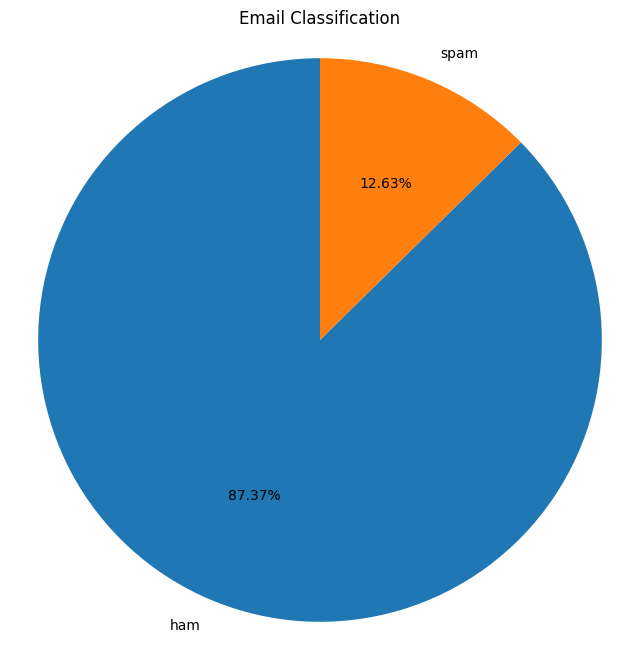

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

# Criar grafico de pizza
wedges, texts, autotexts = ax.pie(
    labels, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90
)

ax.set_title('Email Classification')

ax.axis('equal')
plt.show()


Vemos que os dados estão desbalanceados. Há muito mais hams do que spams.

Vamos analisar o tamanho e estruturas do texto adicionando mais colunas ao dataframe.

In [13]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df.head()

,label,text,num_characters,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [14]:
df[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.286129,1.961308
std,58.236293,13.226400,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,219.000000,38.000000


Vamos analisar essas estatísticas separadamente: primeiro para os dados rotulados em ham e depois com os dados rotulados em spam.

In [15]:
# Ham
df[df['label'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [16]:
# Spam
df[df['label'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


Vamos checar a distribuição do tamanho dos caracteres para as mensagens Ham e Spam.

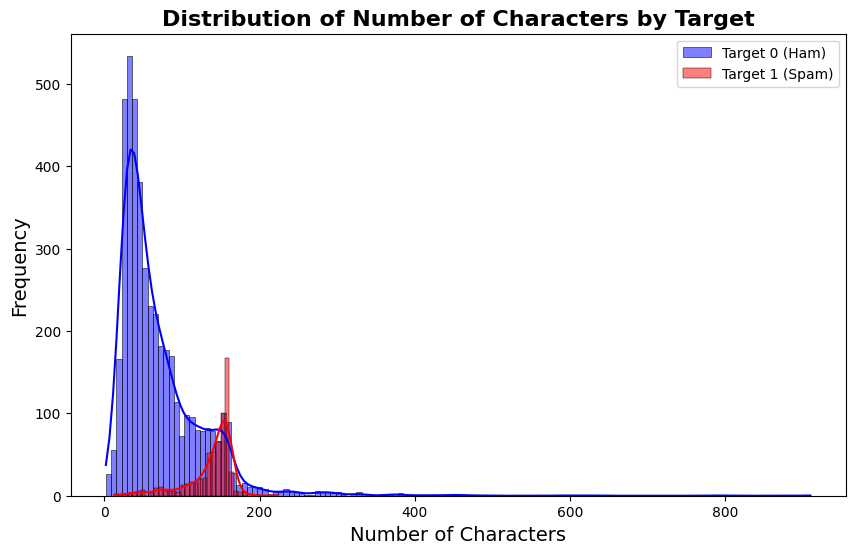

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Histograma para Ham
sns.histplot(df[df['label'] == 0]['num_characters'], color='blue', label='Target 0 (Ham)', kde=True)

# Histograma para Spam
sns.histplot(df[df['label'] == 1]['num_characters'], color='red', label='Target 1 (Spam)', kde=True)

# Labels e titulo
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')

plt.legend()
sns.set(style='whitegrid')
plt.show()


Agora, checar a distribuição da contagem de palavras para as mensagens Ham e Spam.

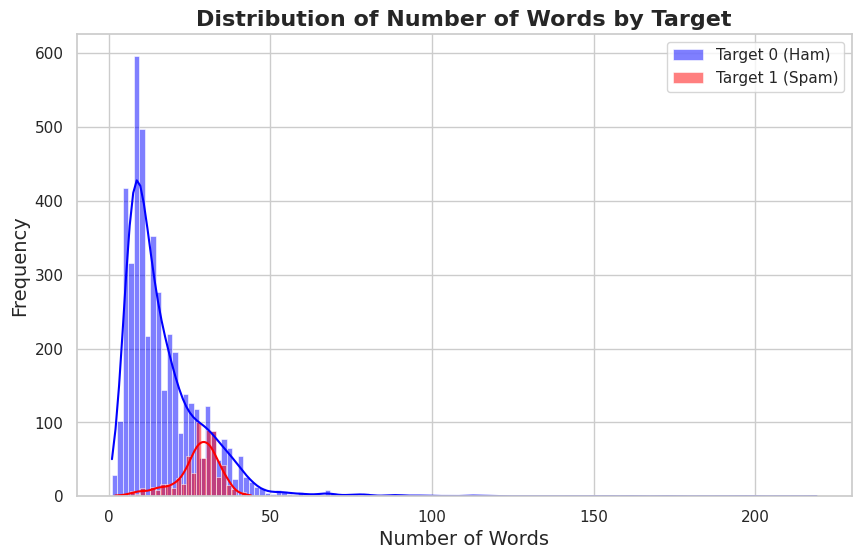

In [18]:
plt.figure(figsize=(10, 6))

# Ham
sns.histplot(df[df['label'] == 0]['num_words'], color='blue', label='Target 0 (Ham)', kde=True)

# Spam
sns.histplot(df[df['label'] == 1]['num_words'], color='red', label='Target 1 (Spam)', kde=True)

plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')

plt.legend()
sns.set(style='whitegrid')
plt.show()


Para traçar múltiplas distribuições bivariadas aos pares em um conjunto de dados, podemos usar a função .pairplot().

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


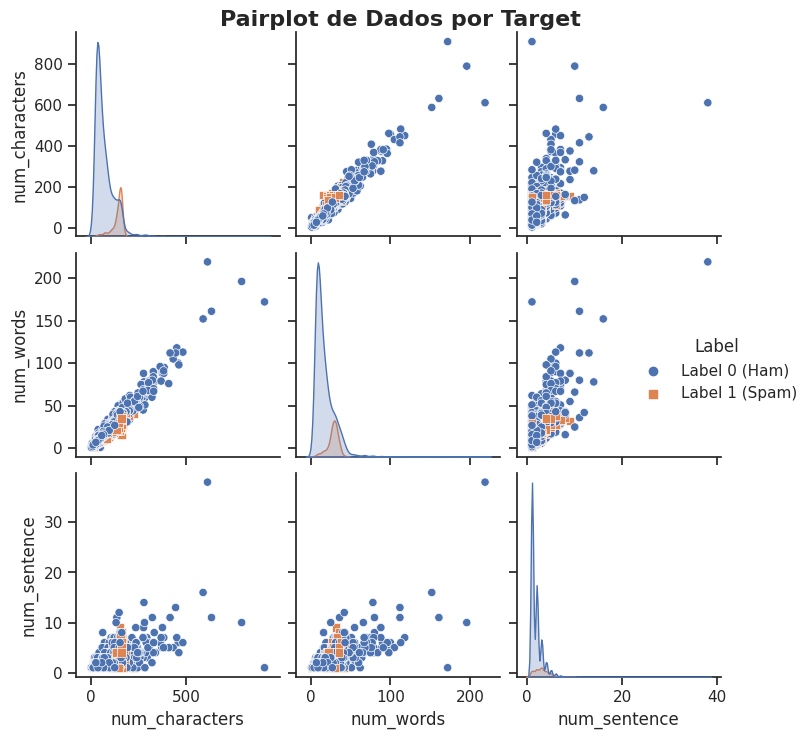

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(df, hue='label', diag_kind='kde', markers=["o", "s"])

# Titulo
g.fig.suptitle("Pairplot de Dados por Target", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)

# Customize the legend
g._legend.set_title('Label')
for t, l in zip(g._legend.texts, ["Label 0 (Ham)", "Label 1 (Spam)"]):
    t.set_text(l)

# Show the pairplot
plt.show()


Um bom parâmetro a ser analisado na exploração dos daos é a correlação entre as variáveis.

In [20]:
df[['label','num_characters', 'num_words', 'num_sentence']].corr()

,label,num_characters,num_words,num_sentence
label,1.000000,0.384717,0.264198,0.267602
num_characters,0.384717,1.000000,0.965307,0.626118
num_words,0.264198,0.965307,1.000000,0.683561
num_sentence,0.267602,0.626118,0.683561,1.000000


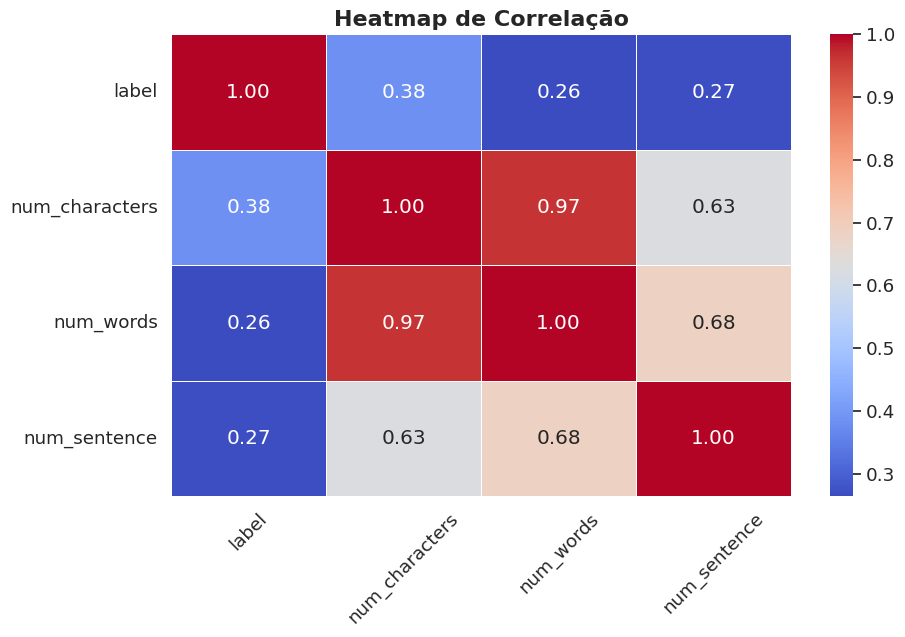

In [21]:
correlation_matrix = df[['label', 'num_characters', 'num_words', 'num_sentence']].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Titulo
plt.title("Heatmap de Correlação", fontsize=16, fontweight='bold')

plt.xticks(rotation=45)
plt.show()


## Preprocessamento dos Dados

Vamos pre-processar os textos dos sms para facilitar a classificação dos algoritmos: retirar caracteres especiais, transformar em lowercase, tokenizar e realizar o processor de steaming.

Segundo GeekforGeeks (https://www.geeksforgeeks.org/python-stemming-words-with-nltk/): "Stemming é o processo de produção de variantes morfológicas de uma palavra raiz/base. Os programas de stemming são comumente chamados de algoritmos de stemming ou stemmers. Um algoritmo de lematização reduz as palavras “chocolates”, “chocolatey” e “choco” à palavra raiz, “chocolate” e “retrieval”, “recuperado”, “recupera” reduzido ao radical “recuperar"."

Além disso, GeekforGeeks (https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/) ainda fala sobre tokenização: "Então, basicamente, a tokenização envolve separar frases e palavras do corpo do texto".

In [22]:
from nltk.stem.porter import PorterStemmer    # Porter Stemmer para stemming

import string     # Lidar com caracteres especiais

ps = PorterStemmer()

# Funcao de pre-processamento
def transform_text(text):
    text = text.lower()   # Lowercase
    
    text = nltk.word_tokenize(text)   # Tokenization
    
    # Remover caracteres especiais
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    # Remover stopwords e pontuacao
    text = y[:]
    y.clear()
    
    # Loop pelos tookens para remover stopwords e pontuacao
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
        
    # Stemming
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    
    # Juntar os tokens transformados em uma unica string
    return " ".join(y)


Vamos criar uma coluna com o texto transformado aplicando a função acima.

In [23]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,label,text,num_characters,num_words,num_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


Com esses textos transformados, vamos visualizar uma WordCloud para os dados Ham e outra para os dados Spam.

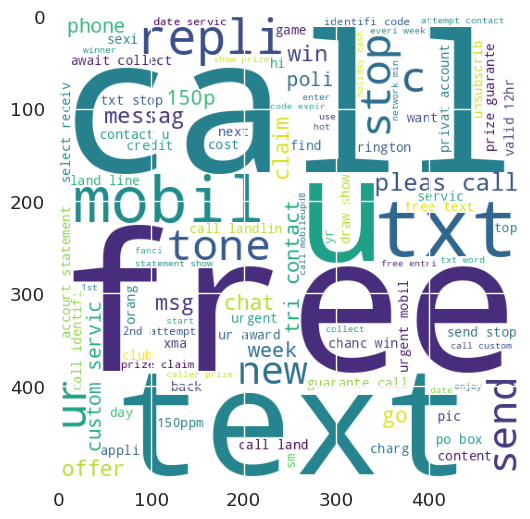

In [24]:
# Spam
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['label'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

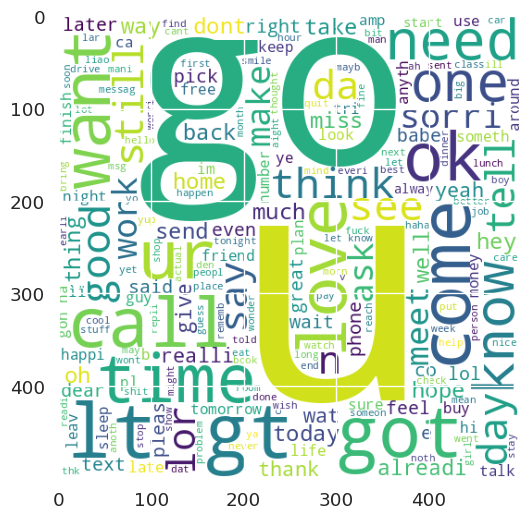

In [25]:
# Ham
ham_wc = wc.generate(df[df['label'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(ham_wc)
plt.show()

Por fim, para encerrar as análises, vamos checar as top 30 para encontradas nos textos de Spam e nos textos de Ham.

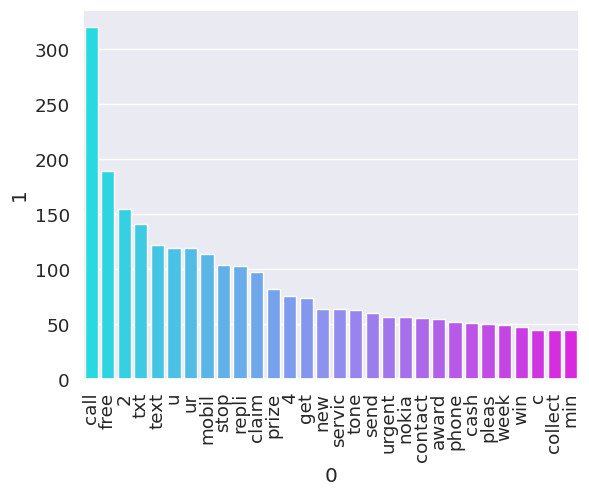

In [26]:
# Spam
spam_carpos = []
for sentence in df[df['label'] == 1]['transformed_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)
        
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

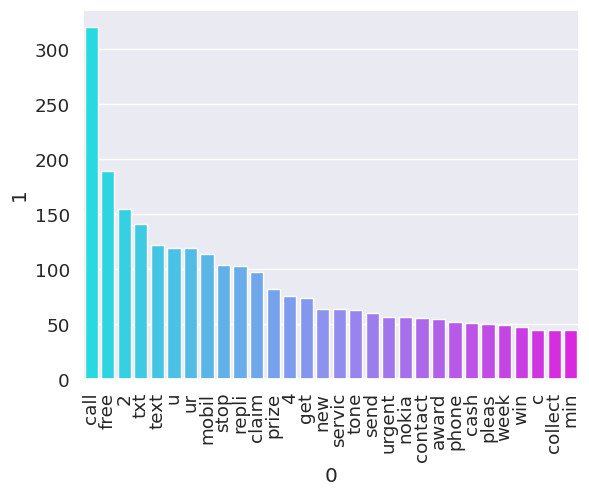

In [27]:
# Ham
ham_carpos = []
for sentence in df[df['label'] == 0]['transformed_text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)
        
filter_ham_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

## Construção do Modelo


Vamos inicializar o CountVectorizer e o TfidVectorizer.

Segundo GeekforGeeks (https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/) "CountVectorizer é uma ótima ferramenta fornecida pela biblioteca scikit-learn em Python. É utilizado para transformar um determinado texto em um vetor com base na frequência (contagem) de cada palavra que ocorre em todo o texto. Isso é útil quando temos vários desses textos e desejamos converter cada palavra de cada texto em vetores (para usar em análises posteriores de texto)".

Ainda (https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/) "TF-IDF significa Term Frequency Inverse Document Frequency of records. Pode ser definido como o cálculo da relevância de uma palavra de uma série ou corpus para um texto. O significado aumenta proporcionalmente ao número de vezes que uma palavra aparece no texto, mas é compensado pela frequência da palavra no corpus (conjunto de dados)". E a vetorização e baseada nesse parâmetro.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfid = TfidfVectorizer(max_features = 3000)

Vamos definir os textos transformados como os features e os rótulos (Spam ou Ham) como as labels do modelo de machine learning.

In [29]:
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['label'].values

Agora, divide-se os dados de teste (20%) e os dados de treinamento (80%).

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 2)

Os modelos utilizados estão expostos abaixo. Será utilizado o sklearn para carregar os modelos e então serão inicializados com prâmetros análogos e um dicionário será criado para facilitar o múltiplo treinamento dos modelos.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

svc = SVC(kernel= "sigmoid", gamma  = 1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2 )
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)    
xgb  = XGBClassifier(n_estimators = 50, random_state = 2)

clfs = {
    'SVC': svc,
    'KNN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'Adaboost': abc,
    'Bgc': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'xgb': xgb
    
}

Por fim, podemos treinar os modelos fazendo um loop pelo dict criado.

In [32]:
from sklearn.metrics import accuracy_score, precision_score
def train_classifier(clfs, X_train, y_train, X_test, y_test):
    clfs.fit(X_train,y_train)
    y_pred = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy , precision

## Validação dos Modelos


Primeiramente, vamos consultar a acurácia e precisão (precisão é a razão tp/(tp + fp) onde tp é o número de verdadeiros positivos e fp o número de falsos positivos, é intuitivamente a capacidade do classificador de não rotular como positiva uma amostra negativa) para os dados de teste.

In [33]:
accuracy_scores = []
precision_scores = []
for name , clfs in clfs.items():
    current_accuracy, current_precision = train_classifier(clfs, X_train, y_train, X_test, y_test)
    print()
    print("Para: ", name)
    print("Acuracia: ", current_accuracy)
    print("Precisao: ", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    


Para:  SVC
Acuracia:  0.9748549323017408
Precisao:  0.9666666666666667

Para:  KNN
Acuracia:  0.9052224371373307
Precisao:  1.0

Para:  NB
Acuracia:  0.9729206963249516
Precisao:  1.0

Para:  DT
Acuracia:  0.9323017408123792
Precisao:  0.8469387755102041

Para:  LR
Acuracia:  0.9574468085106383
Precisao:  0.9519230769230769

Para:  RF
Acuracia:  0.971953578336557
Precisao:  0.9739130434782609

Para:  Adaboost
Acuracia:  0.9642166344294004
Precisao:  0.9316239316239316

Para:  Bgc
Acuracia:  0.9545454545454546
Precisao:  0.8527131782945736

Para:  ETC
Acuracia:  0.9777562862669246
Precisao:  0.9831932773109243

Para:  GBDT
Acuracia:  0.9487427466150871
Precisao:  0.9292929292929293

Para:  xgb
Acuracia:  0.9690522243713733
Precisao:  0.9416666666666667
